In [304]:
import yfinance as yf
import pandas as pd
import pandas_ta
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [305]:
snp500 = yf.Ticker("SPY").history(period="max") # all data for the GSPC index fund since 1927
snp500.columns = snp500.columns.str.lower()


<AxesSubplot:xlabel='Date'>

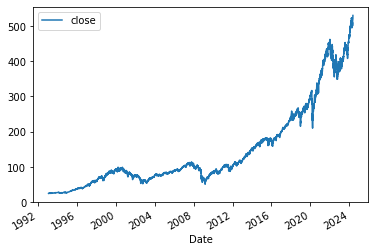

In [306]:
del snp500["dividends"] # get rid of stock splits and dividends since this is an index fund
del snp500["stock splits"]

snp500["tomorrow"] = snp500["close"].shift(-1) # make a column representing the closing price for the next day
snp500["target"] = (snp500["tomorrow"] > snp500["close"]).astype(int) # make a column for the direction of the stock (up or down)
# "target" will be our y value

snp500 = snp500.loc["1990-01-02":].copy() # only considering data from 1990 onwards
snp500.plot.line(y="close", use_index=True)

In [307]:
# adding close ratios and trends columns for 2, 5, 10, 30, 60, 250, and 1000 trading days
# these will be our predictors
horizons = [2, 5, 10, 30, 60, 250, 1000]
predictors = [f"close_ratio_{horizon}" for horizon in horizons] + [f"trend_{horizon}" for horizon in horizons]
    


def calculate_ratios_trends(data):
    for horizon in horizons:
        rolling_averages = data.rolling(horizon).mean()

        ratio_column = f"close_ratio_{horizon}"
        data[ratio_column] = data["close"] / rolling_averages["close"]

        trend_column = f"trend_{horizon}"
        data[trend_column] = data.shift(1).rolling(horizon).sum()["target"]
        
    return data

snp500 = calculate_ratios_trends(snp500).copy()
mask = snp500.isnull().any(axis=1)
mask.iloc[-1] = False  # Exclude the last row

# Filter out rows with NaN values
snp500 = snp500[~mask]

In [308]:
length_snp = len(snp500)
train_test_split = 0.8 # 80% of the data will be used to train

scaler = StandardScaler()
snp500_scaled = scaler.fit_transform(snp500[predictors])

snp500_train = snp500.iloc[0:int(length_snp * train_test_split)].copy()  # snp500.iloc[:-500].copy() 
snp500_test = snp500.iloc[int(length_snp * train_test_split):-1].copy()  # snp500.iloc[-500:].copy()
snp500_last_row = snp500.iloc[[-1]]

snp500_train_scaled = snp500_scaled[0:int(length_snp * train_test_split)] # scaler.fit_transform(snp500_train[predictors])
snp500_test_scaled = snp500_scaled[int(length_snp * train_test_split):-1] # scaler.fit_transform(snp500_test[predictors])
snp500_last_row_scaled = snp500_scaled[[-1]]

print(snp500_scaled.shape, snp500.shape)

(6880, 14) (6880, 22)


In [309]:
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(snp500_train_scaled, snp500_train["target"])


GradientBoostingClassifier(n_estimators=300, random_state=42)

In [310]:
# generate predictions 
def generate_predictions(model, data, data_scaled, predictors, threshold=0.4):

    predictions = model.predict_proba(data_scaled)[:, 1] # this will give us a probability, not a 1 or a 0
    
    predictions[predictions >= threshold] = 1 # set the threshold; if the probablity is over the threshold, only then we will count it
    predictions[predictions < threshold] = 0

    predictions = pd.Series(predictions, index=data.index, name="predictions")

    p_score = precision_score(data["target"], predictions) # precision score, true positives divided by true + false positives
    print(f"Precision score for the split: {p_score}")
    
    print("Total buy days %: ", predictions.sum() * 100 / len(predictions), "%") # percentage of days the model recommends to buy
    
    return predictions

In [311]:
training_set_predictions = generate_predictions(gb_model, snp500_train, snp500_train_scaled, predictors) # training predictions (will be higher)
testing_set_predictions = generate_predictions(gb_model, snp500_test, snp500_test_scaled, predictors) # testing predictions 


Precision score for the split: 0.6055760557605576
Total buy days %:  88.62645348837209 %
Precision score for the split: 0.5599654874892148
Total buy days %:  84.2909090909091 %


In [312]:
# this will simulate you buying and selling based on the model alone
# this will simulate you buying everyday and selling everyday, regardless of what the model says
# model will be the random forest classifier, start and end date are self explanatory, starting_total will be the 
# amount of money you start with, percentage_traded_per_day will be the percentage of money traded everyday, and
# predictors will be the the predictors we came up with earlier.
def simulate_paper_trading(model, start_date, end_date, starting_total, 
                           percentage_traded_per_day, predictors, dataset=None, dataset_scaled=None):
    total = starting_total
    start_date_int, end_date_int = "", ""
    
    if dataset is None:
        try:
            start_date_int = snp500.index.get_loc(start_date) 
        except Exception as e:
            print("Start date is a non-trading day. Please enter a valid trading day.")
            return
        try:
            end_date_int = snp500.index.get_loc(end_date)   
        except Exception as e:
            print("Start date is a non-trading day. Please enter a valid trading day.")
            return
    
    # if you provide the dataset, ignore the start and end date
    dataset = snp500.iloc[start_date_int:end_date_int + 1].copy() if dataset is None else dataset
    predictions = generate_predictions(model, dataset, dataset_scaled, predictors)
    
    for i in range(len(predictions)):
        current_stock_price = dataset.iloc[i]["close"]
        if predictions[i] == 1:
            day_profit = ((dataset.iloc[i]["tomorrow"] - dataset.iloc[i]["close"]) 
                          * ((percentage_traded_per_day * total) / current_stock_price))
            total += day_profit
            
            
    print(f"Total amount after trading via algorithm: {total}")
    
    total = starting_total
    
    for i in range(len(predictions)):
        current_stock_price = dataset.iloc[i]["close"]
        day_profit = ((dataset.iloc[i]["tomorrow"] - dataset.iloc[i]["close"]) 
                      * ((percentage_traded_per_day * total) / current_stock_price))
        total += day_profit
        
    print(f"Total amount from buying and selling everyday without pattern: {total}")

In [313]:
start_date = "2022-05-03" # ignore if the dataset is already provided
end_date = "2024-05-01" # ignore if the dataset is already provided
starting_total = 10000
percentage_traded_per_day = 1 # fraction of your total you trade with; stick with 1 since we always give 100% into everything we do, even gambling
simulate_paper_trading(gb_model, start_date, end_date, starting_total, 
                       percentage_traded_per_day, predictors, dataset=snp500_test, dataset_scaled=snp500_test_scaled)


Precision score for the split: 0.5599654874892148
Total buy days %:  84.2909090909091 %
Total amount after trading via algorithm: 32704.859760792027
Total amount from buying and selling everyday without pattern: 21683.09130930535


In [314]:
def predict_next_day():
    data = np.vstack((snp500_train_scaled, snp500_test_scaled))
    gb_model.fit(data, snp500.iloc[:-1]["target"])
    prediction = gb_model.predict_proba(snp500_last_row_scaled)[:, 1]
    return prediction

predict_next_day()

array([0.67967709])